### Pre...

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# this allows plots to appear directly in the notebook
%matplotlib inline

## data::inspect

### data::inspect::read

In [70]:
# read data into a DataFrame
data = pd.read_csv('D:/MyCode/Playground/eMeL/datas/bikes/train.csv')
data.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


`--->` 12 features, 10886 records

### data::inspect::clean-up

Docs:
  * [Azure](https://docs.microsoft.com/en-us/azure/machine-learning/machine-learning-data-science-prepare-data)

### Overall cleanup

Some overall observations of the data:
 1. The 'datetime' field should be split: we care about the hour and the month.
 2. The 'holiday' and the 'working day' (and a third, implied, 'weekend day') fields should be merged into one categorical field.
 3. Remove unused fields. E.g. the 'casual' and the 'registered' fields bring no new information (their sum is actually the target, 'count'). They should be removed.
 4. Fix fields types. E.g. the 'season' and the 'weather' fields are ordinal and should be categorical (they are not comparable, summer (2) is not greater than spring (1))
 5. Check for completeness.
 
Okay, let's get to work.

#### 1. Split datetime

In [71]:
data.datetime = data.datetime.apply(pd.to_datetime)
data['month'] = data.datetime.apply(lambda d: d.month)
data['day'] = data.datetime.apply(lambda d: d.day)
data['hour'] = data.datetime.apply(lambda d: d.hour)
data.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2


#### 2. Merge fields that represent the type of the day.

In [72]:
data['daytype'] = data.apply(lambda row: 0 if (row['workingday'] == 1) else
                             1 if (row['holiday'] == 1) else 2,
                            axis = 'columns')
data.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,month,day,hour,daytype
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,1,1,0,2
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1,1,1,2
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,1,1,2,2


#### 3. Remove unused

In [73]:
data.drop(['registered', 'casual', 'datetime', 'holiday', 'workingday'], axis='columns', inplace=True)

#### 4. Fix field types

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
season       10886 non-null int64
weather      10886 non-null int64
temp         10886 non-null float64
atemp        10886 non-null float64
humidity     10886 non-null int64
windspeed    10886 non-null float64
count        10886 non-null int64
month        10886 non-null int64
hour         10886 non-null int64
day          10886 non-null int64
daytype      10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 935.6 KB


In [67]:
categorical = ['season', 'weather', 'month', 'hour', 'day', 'daytype']
ordinal = ['temp', 'atemp', 'humidity', 'windspeed']

for c in categorical:
    data[c] = data[c].astype('category')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
season       10886 non-null category
weather      10886 non-null category
temp         10886 non-null float64
atemp        10886 non-null float64
humidity     10886 non-null int64
windspeed    10886 non-null float64
count        10886 non-null int64
month        10886 non-null category
day          10886 non-null category
hour         10886 non-null category
daytype      10886 non-null category
dtypes: category(6), float64(3), int64(2)
memory usage: 489.6 KB


#### 5. Check for completeness.  
Check for NaNs.

In [58]:
#data[data.isnull().any(axis=1)]
data.isnull().values.any()

False

`--->` Data is complete. Yay!

### data::inspect::analyze

 * Corr matrix

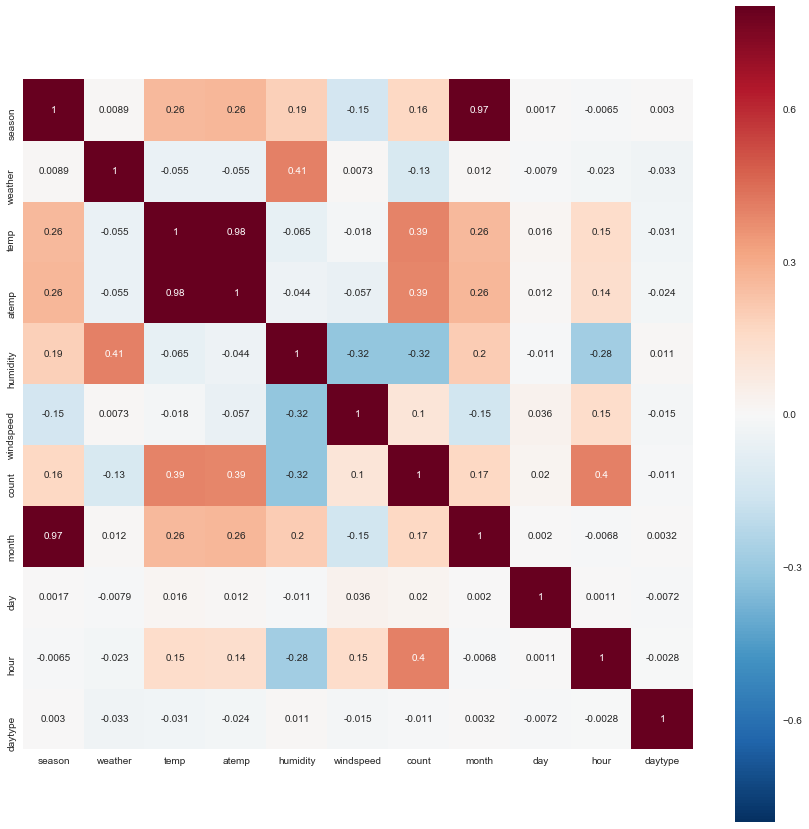

In [74]:
import seaborn as sb

correlation_matrix = data.corr(method='pearson')
plt.subplots(figsize = (15, 15))

sb.heatmap(correlation_matrix, vmax=.8, square=True, annot=True)
plt.show()

`--->` 'count' is thightest related to the 'hour', 'temp' and 'humidity'.

 * Plot data & regression (Pearson) for top three correlated features.

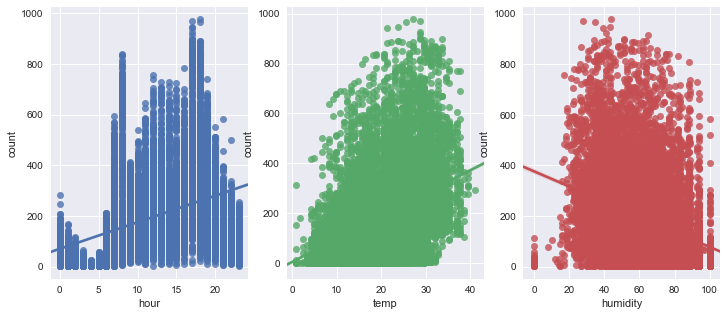

In [90]:
fig,(ax1, ax2, ax3) = plt.subplots(ncols=3)
fig.set_size_inches(12, 5)
sb.regplot(x="hour", y="count", data=data, ax=ax1)
sb.regplot(x="temp", y="count", data=data, ax=ax2)
sb.regplot(x="humidity", y="count", data=data, ax=ax3)

## pipeline::build

#### 4. Fix field types

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
season       10886 non-null int64
weather      10886 non-null int64
temp         10886 non-null float64
atemp        10886 non-null float64
humidity     10886 non-null int64
windspeed    10886 non-null float64
count        10886 non-null int64
month        10886 non-null int64
hour         10886 non-null int64
day          10886 non-null int64
daytype      10886 non-null int64
dtypes: float64(3), int64(8)
memory usage: 935.6 KB


In [93]:
categorical = ['season', 'weather', 'month', 'hour', 'day', 'daytype']
ordinal = ['temp', 'atemp', 'humidity', 'windspeed']

for c in categorical:
    data[c] = data[c].astype('category')
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 11 columns):
season       10886 non-null category
weather      10886 non-null category
temp         10886 non-null float64
atemp        10886 non-null float64
humidity     10886 non-null int64
windspeed    10886 non-null float64
count        10886 non-null int64
month        10886 non-null category
day          10886 non-null category
hour         10886 non-null category
daytype      10886 non-null category
dtypes: category(6), float64(3), int64(2)
memory usage: 489.6 KB


In [98]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

X = data.drop('count', axis='columns')
y = list(data['count'].values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)